In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
import gsw
from cmocean import cm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=6)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.38:53969 Dashboard: http://10.148.0.38:8787/status,Cluster Workers: 24 Cores: 96 Memory: 223.44 GiB


________________
## Steric height calculation from buoyancy profiles

In [4]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'
grid_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(grid_dir_zarr+'Grid.nc', decode_coords=True)
ds_B = xr.open_zarr(grid_dir_zarr+'Buoy_total_rechunk.zarr')

ds = xr.merge([ds_B,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
ds.persist()

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    ...       ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
  * lat_g    (lat_g) float32 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float32 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
Data variables:
    Buoy     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 69.7 GB


,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10452 Tasks,10452 Chunks
Type,float32,numpy.ndarray


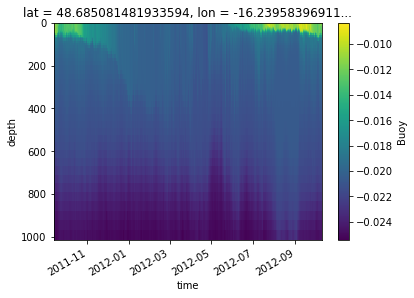

In [17]:
ds.Buoy.sel(lat= 48.6875,lon=-16.1875,method='nearest').plot(x='time', y='depth', yincrease=False)

In [9]:
steric_height_0_1000 = ds.Buoy.integrate("depth")
steric_height_0_1000.load()

<xarray.DataArray 'Buoy' (time: 9415, lat: 201, lon: 177)>
array([[[-20.93851589, -20.89940703, -20.87582088, ..., -20.8649573 ,
         -20.88127254, -20.90573309],
        [-20.92211369, -20.89256023, -20.8765443 , ..., -20.85158753,
         -20.88029032, -20.9112297 ],
        [-20.90973835, -20.88664683, -20.87650638, ..., -20.8494361 ,
         -20.8885695 , -20.92678271],
        ...,
        [-21.60208331, -21.63476066, -21.66805644, ..., -20.84851121,
         -20.84608328, -20.84105071],
        [-21.591912  , -21.61837523, -21.64725564, ..., -20.8473607 ,
         -20.84464456, -20.83913691],
        [-21.57830075, -21.59968938, -21.62624228, ..., -20.84161622,
         -20.83785547, -20.83140692]],

       [[-20.93549342, -20.91448723, -20.89525417, ..., -20.83985392,
         -20.87486332, -20.91386065],
        [-20.91891411, -20.89808615, -20.88286352, ..., -20.85719739,
         -20.89277228, -20.93403455],
        [-20.90416015, -20.88962245, -20.88211319, ..., -20.87479081,
         -20.90894419, -20.94204852],
...
        [-20.89116271, -20.88056417, -20.87838441, ..., -21.47950819,
         -21.48539999, -21.48978732],
        [-20.9185474 , -20.90761226, -20.90292992, ..., -21.46698394,
         -21.47781689, -21.49184757],
        [-20.9447006 , -20.93221887, -20.92264557, ..., -21.46533577,
         -21.47323668, -21.48724327]],

       [[-20.68349251, -20.64862897, -20.62767327, ..., -20.64130304,
         -20.64608294, -20.62456044],
        [-20.76614927, -20.72074146, -20.67207629, ..., -20.63161235,
         -20.61319487, -20.59294551],
        [-20.78623316, -20.73564785, -20.67150375, ..., -20.62897077,
         -20.59467206, -20.57930716],
        ...,
        [-20.83620541, -20.84214004, -20.84606175, ..., -21.54931888,
         -21.53427611, -21.52386886],
        [-20.84483238, -20.85533911, -20.86567295, ..., -21.54469383,
         -21.53047378, -21.51733019],
        [-20.86644871, -20.8740056 , -20.88666745, ..., -21.54272571,
         -21.52989244, -21.51018917]]])
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC       (lat, lon) float32 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    YC       (lat, lon) float32 47.4 47.4 47.4 47.4 ... 49.99 49.99 49.99 49.99
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    SN       (lat, lon) float32 -2.519e-13 -0.0 -0.0 ... 2.653e-13 -2.652e-13
    Depth    (lat, lon) float32 4.659e+03 4.648e+03 ... 4.07e+03 4.057e+03
    rA       (lat, lon) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06

In [11]:
sh = -steric_height_0_1000/9.8

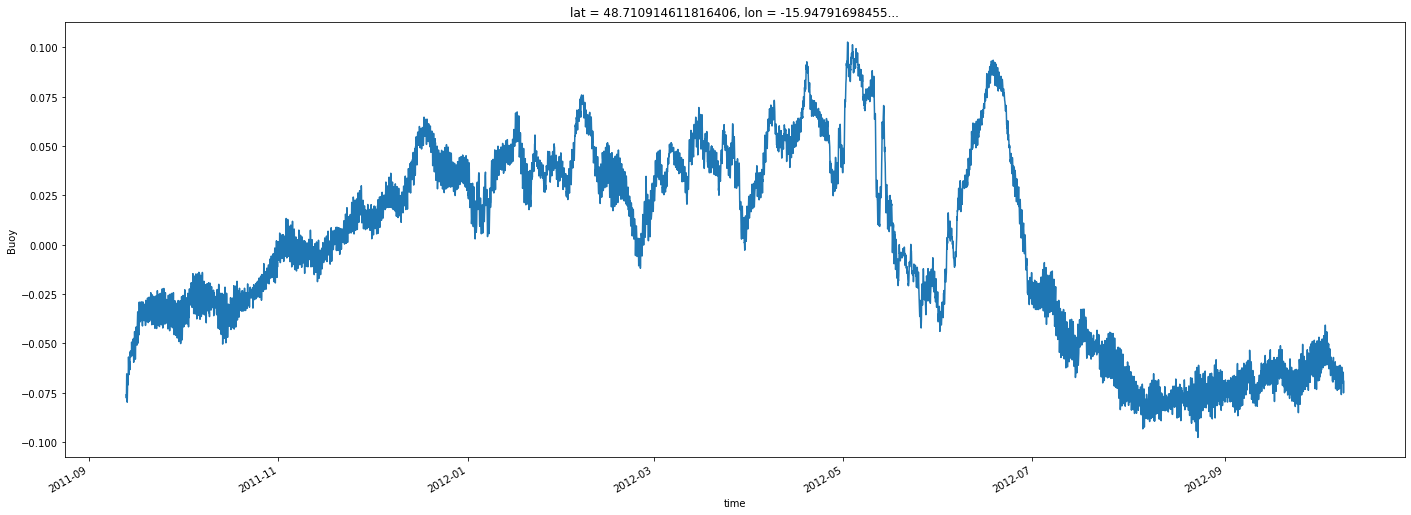

In [12]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
(sh - sh.mean('time')).isel(lat=100,lon=100).plot(x='time')

_________
## Glider trajectory

In [5]:
ds

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


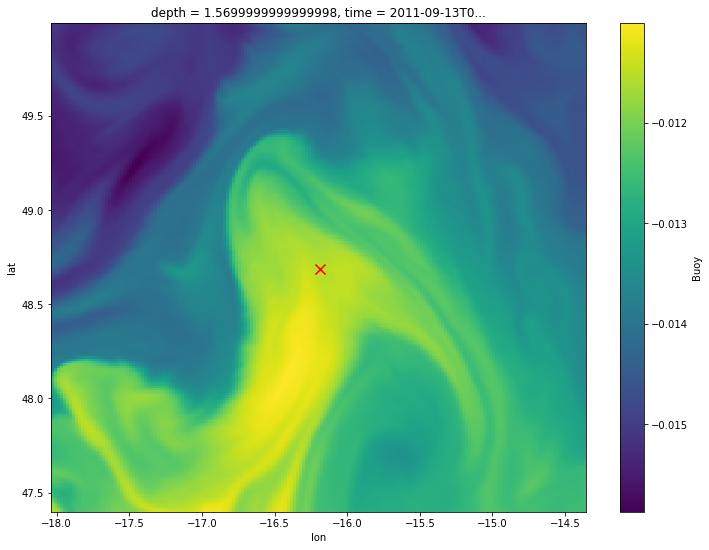

In [8]:
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
ds.Buoy.isel(time=1,depth=1).plot(x='lon', y='lat')
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')

_______
## An ideal try

In [24]:
lon_interp = np.linspace(-17, -15, 9415)
lat_interp = np.linspace(48, 49, 9415)
depth_interp = np.linspace(1, 990, 9415)
T = np.arange(0, 9415, 1)
sla_nearest = lon_interp
sla_interp = lon_interp
#T = np.arange(0, 5, 1)

In [25]:
# this takes quite long
for t in T: 

    sla_Centre_nearest = ds.Buoy.isel(time=t).sel(lat=lat_interp[t], lon=lon_interp[t], depth=depth_interp[t], method='nearest')
    sla_Centre_interp  = ds.Buoy.isel(time=t).interp(lat=lat_interp[t], lon=lon_interp[t], depth=depth_interp[t])
    sla_nearest[t] = sla_Centre_nearest.values
    sla_interp[t] = sla_Centre_interp.values

In [25]:
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

In [26]:
ds = xr.Dataset({'sla_nearest':(('time'),sla_nearest),'sla_interp':(('time'),sla_interp)}, 
                {'time':time_day,'lat':lat_interp,'lon':lon_interp,'depth':depth_interp})
#ds = ds.assign_coords(time=time_day) 
ds

<xarray.Dataset>
Dimensions:      (depth: 9415, lat: 9415, lon: 9415, time: 9415)
Coordinates:
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat          (lat) float64 48.0 48.0 48.0 48.0 48.0 ... 49.0 49.0 49.0 49.0
  * lon          (lon) float64 -0.01323 -0.01325 -0.01326 ... -0.02464 -0.02465
  * depth        (depth) float64 1.0 1.105 1.21 1.315 ... 989.8 989.9 990.0
Data variables:
    sla_nearest  (time) float64 -0.01323 -0.01325 -0.01326 ... -0.02464 -0.02465
    sla_interp   (time) float64 -0.01323 -0.01325 -0.01326 ... -0.02464 -0.02465

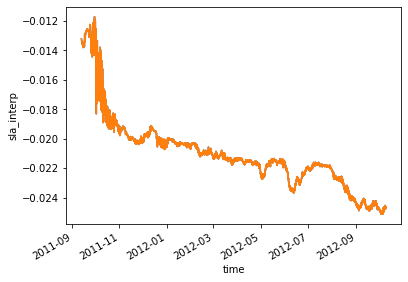

In [28]:
ds.sla_nearest.plot()
ds.sla_interp.plot()

__________
## designed

In [4]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

In [5]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [6]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)
LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [7]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'
grid_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

ds_B = xr.open_zarr(grid_dir_zarr+'Buoy_total_rechunk.zarr')

lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds_B = ds_B.assign_coords(lat=lat) 
ds_B = ds_B.assign_coords(lon=lon)


# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_B = ds_B.assign_coords(time=time_day) 
print(ds_B)
print('\n data size: %.1f GB' %(ds_B.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat      (lat) >f4 47.4 47.42 47.43 47.44 47.46 ... 49.95 49.96 49.98 49.99
  * lon      (lon) >f4 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    Buoy     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 69.7 GB


In [8]:
ds_B_small = ds_B.Buoy.isel(lat=slice(45,125),lon=slice(75,100))
print(ds_B_small)
print('\n data size: %.1f GB' %(ds_B_small.nbytes / 1e9))

<xarray.DataArray 'Buoy' (time: 9415, depth: 52, lat: 80, lon: 25)>
dask.array<getitem, shape=(9415, 52, 80, 25), dtype=float32, chunksize=(9415, 1, 1, 25), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat      (lat) >f4 48.0 48.01 48.02 48.04 48.05 ... 48.98 48.99 49.01 49.02
  * lon      (lon) >f4 -16.47 -16.45 -16.43 -16.41 ... -16.01 -15.99 -15.97

 data size: 3.9 GB


In [9]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

file_out = out_dir_zarr+'/ds_B_small.zarr'
%time ds_B_small.to_dataset().to_zarr(file_out, mode='w')

CPU times: user 19.2 s, sys: 796 ms, total: 20 s
Wall time: 1min 24s


In [7]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

ds_B = xr.open_zarr(out_dir_zarr+'ds_B_small.zarr')
ds_B

,Array,Chunk
Bytes,3.65 GiB,919.43 kiB
Shape,"(9415, 52, 80, 25)","(9415, 1, 1, 25)"
Count,4161 Tasks,4160 Chunks
Type,float32,numpy.ndarray


In [8]:
ds_B.load()

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 80, lon: 25, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float32 48.0 48.01 48.02 48.04 ... 48.98 48.99 49.01 49.02
  * lon      (lon) float32 -16.47 -16.45 -16.43 -16.41 ... -16.01 -15.99 -15.97
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    Buoy     (time, depth, lat, lon) float32 -0.01108 -0.0111 ... -0.02381

In [108]:
import scipy.io
mat = scipy.io.loadmat('/home1/scratch/xyu/OSMOSIS_llc4320/traj_392days.mat') 
lat_new = np.transpose(mat['lat'])
lon_new = np.transpose(mat['lon'])
z_new = np.transpose(mat['z'])

In [109]:
nlength = z_new.size
nlength

564480

In [110]:
# define (real) time
def iters_to_date(iters, delta_t=60.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_new = iters_to_date(np.arange(nlength))

In [111]:
T = np.arange(0, nlength, 1)
B_new_nearest = np.linspace(-17., -15., nlength)

In [114]:
time_new[0]

datetime.datetime(2011, 9, 13, 0, 0)

In [115]:
time_new[-1]

datetime.datetime(2012, 10, 8, 23, 59)

In [116]:
%%time
for t in T: 

    b_new_nearest = ds_B.Buoy.sel(time=time_new[t], lat=lat_new[t], lon=lon_new[t], depth=z_new[t], method='nearest')
    B_new_nearest[t] = b_new_nearest.values


CPU times: user 21min 40s, sys: 21.2 s, total: 22min 1s
Wall time: 21min 42s


In [117]:
lat_new = np.array(lat_new)
lat = xr.DataArray(lat_new, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')

lon_new = np.array(lon_new)
lon = xr.DataArray(lon_new, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')

z_new = np.array(z_new)
depth = xr.DataArray(z_new, dims=['depth', 'none'])
depth = xr.DataArray.squeeze(depth, dim='none')

In [118]:
ds_new = xr.Dataset({'B_new_nearest':(('time'),B_new_nearest)}, 
                    {'time':time_new,'lat':lat[0:nlength],'lon':lon[0:nlength],'depth':depth[0:nlength]})
ds_new

<xarray.Dataset>
Dimensions:        (depth: 564480, lat: 564480, lon: 564480, time: 564480)
Coordinates:
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-10-08T23:59:00
  * lat            (lat) float64 48.69 48.69 48.69 48.69 ... 48.69 48.69 48.69
  * lon            (lon) float64 -16.19 -16.19 -16.19 ... -16.19 -16.19 -16.19
  * depth          (depth) float64 513.1 526.1 539.2 552.2 ... 473.9 486.9 500.0
Data variables:
    B_new_nearest  (time) float64 -0.02102 -0.02112 -0.02112 ... -0.0211 -0.0212

In [119]:
file_out = out_dir_zarr+'/Buoy_traj.nc'
%time ds_new.to_netcdf(file_out, mode='w')

CPU times: user 52 ms, sys: 20 ms, total: 72 ms
Wall time: 69.5 ms


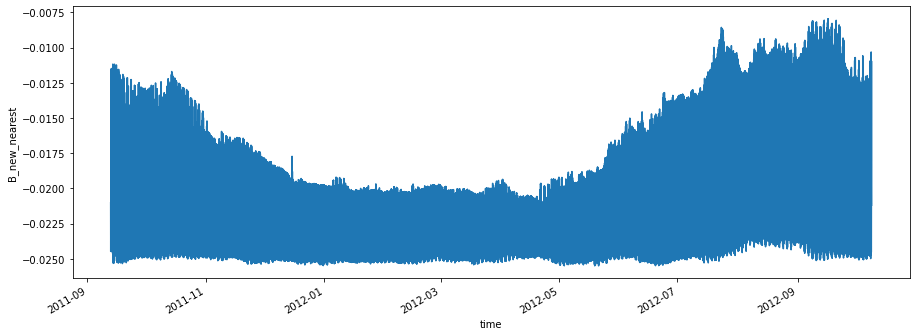

In [121]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ds_new.B_new_nearest.plot(x='time')

(-0.04, 0.0)

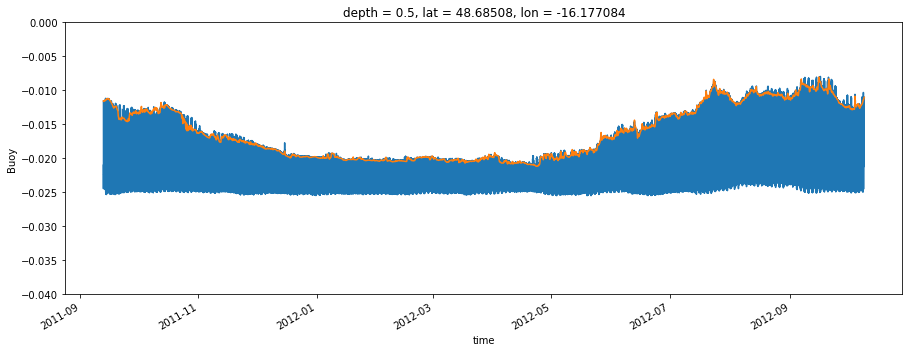

In [122]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ds_new.B_new_nearest.plot()
ds_B.Buoy.sel(lat=48.6875, lon=-16.1875, depth=1, method='nearest').plot()
ax.set_ylim([-0.04, 0.])


In [25]:
ds_B.Buoy.sel(lat=48.6875, lon=-16.1875, depth=1, method='nearest')

<xarray.DataArray 'Buoy' (time: 9415)>
array([-0.01155975, -0.01158162, -0.01160478, ..., -0.01103193,
       -0.01101705, -0.01101621], dtype=float32)
Coordinates:
    depth    float64 0.5
    lat      float32 48.69
    lon      float32 -16.18
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00

## Real trajectory

In [123]:
import scipy.io
mat = scipy.io.loadmat('/home1/scratch/xyu/OSMOSIS_llc4320/glider_trajectory.mat') 
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov 15 16:19:47 2022',
 '__version__': '1.0',
 '__globals__': [],
 'sg_lat_interp': array([[48.69744167, 48.69744167, 48.69744167, ..., 48.68183333,
         48.68183333, 48.68183333]]),
 'sg_lon_interp': array([[-16.13368333, -16.13368333, -16.13368333, ..., -16.19406667,
         -16.19406667, -16.19406667]]),
 'sg_pres_interp': array([[323.5479195 , 330.67237499, 337.81783586, ...,  70.6208662 ,
          77.25781952,  84.39413994]])}

In [126]:
lat_new = np.transpose(mat['sg_lat_interp'])
lon_new = np.transpose(mat['sg_lon_interp'])
z_new = np.transpose(mat['sg_pres_interp'])

In [150]:
nlength = z_new.size
nlength

525601

In [151]:
# define (real) time
def iters_to_date(iters, delta_t=60.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_new = iters_to_date(np.arange(nlength))

In [152]:
T = np.arange(0, nlength, 1)
B_new_nearest = np.linspace(-17., -15., nlength)

In [153]:
time_new[0]

datetime.datetime(2011, 9, 13, 0, 0)

In [154]:
time_new[-1]

datetime.datetime(2012, 9, 12, 0, 0)

In [155]:
%%time
for t in T: 

    b_new_nearest = ds_B.Buoy.sel(time=time_new[t], lat=lat_new[t], lon=lon_new[t], depth=z_new[t], method='nearest')
    B_new_nearest[t] = b_new_nearest.values


CPU times: user 19min 57s, sys: 18.8 s, total: 20min 16s
Wall time: 19min 59s


In [156]:
lat_new = np.array(lat_new)
lat = xr.DataArray(lat_new, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')

lon_new = np.array(lon_new)
lon = xr.DataArray(lon_new, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')

z_new = np.array(z_new)
depth = xr.DataArray(z_new, dims=['depth', 'none'])
depth = xr.DataArray.squeeze(depth, dim='none')

In [157]:
ds_new = xr.Dataset({'B_new_nearest':(('time'),B_new_nearest)}, 
                    {'time':time_new,'lat':lat[0:nlength],'lon':lon[0:nlength],'depth':depth[0:nlength]})
ds_new

<xarray.Dataset>
Dimensions:        (depth: 525601, lat: 525601, lon: 525601, time: 525601)
Coordinates:
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-09-12
  * lat            (lat) float64 48.7 48.7 48.7 48.7 ... 48.68 48.68 48.68 48.68
  * lon            (lon) float64 -16.13 -16.13 -16.13 ... -16.19 -16.19 -16.19
  * depth          (depth) float64 323.5 330.7 337.8 344.7 ... 70.62 77.26 84.39
Data variables:
    B_new_nearest  (time) float64 -0.0204 -0.0204 -0.0204 ... -0.01784 -0.01815

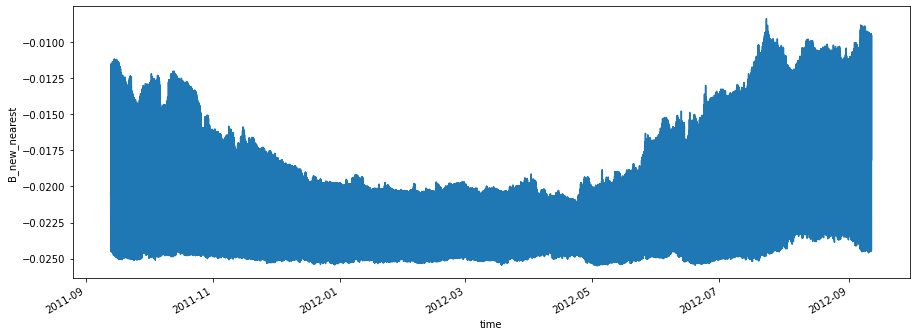

In [158]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ds_new.B_new_nearest.plot(x='time')

In [159]:
file_out = out_dir_zarr+'/Buoy_traj_real.nc'
%time ds_new.to_netcdf(file_out, mode='w')

CPU times: user 52 ms, sys: 20 ms, total: 72 ms
Wall time: 72.6 ms


In [ ]:
cluster.close()